# Kalman Filter: Helical track

Extract 5 parameters ( typically longitudinal momentum, transverse momentum and and vertex position in a particle-physics context ) from a list of points ("hits") in 3-dimensional space.

In [1]:
%matplotlib inline
#%pylab --no-import-all

#  mainly equivalent to 
import  numpy as np
import matplotlib.pyplot as plt
# allow python3 syntax
from __future__ import division, print_function, absolute_import
# 3d projections in plot
from mpl_toolkits.mplot3d import Axes3D
# local file with often used functions
import kalman as k

In [2]:
# %load kalman.py

import numpy as np
import matplotlib.pyplot as plt



def kalman_predict( A, # transition matrix 
            r, # measurement error matrix
            H_k, # list of transformation matrices from state vector to measurement
            p, # initial variance on prediction
            xkal, # estimated state vector
            xpredict, # predicted state vector
            xmeas): # measurements
    for i in range(1, xkal.shape[1]): # for each measurement do 
        # shorthand for current transformation matrix
        H = H_k[i]
        # prediction: recursive formula
        xpredict[:, i] = np.dot(A, xkal[:, i - 1])
        # predict covariance  
        p = np.dot(np.dot(A, p), A.T)
        # construct kalman gain matrix according to prediction equations
        # higher gain leads to higher influence of measurement,
        # lower gain to higher influence of predicion
        K = np.dot(np.dot(p, H.T), 
            np.linalg.inv(np.dot(np.dot(H, p), H.T) + r))
        # construct estimate from prediction and gain 
        xkal[:, i] = xpredict[:, i] + np.dot(K, (xmeas[:, i] - np.dot(H, xpredict[:, i])))
        # update covariance with gain
        p = np.dot(np.eye(K.shape[0]) - np.dot(K, H), p)
    return xkal, xpredict

def plot_results(xkal, xpredict, xmeas, xtrue):
    fig1 = plt.figure()
    ax1 = plt.axes()
    plt.plot(xtrue, 'b-', label = 'True')
    plt.plot(xmeas[0].T, 'rx', label = 'Measurement')
    plt.plot(xpredict[0].T, 'g.',  label = 'Prediction')
    plt.plot(xkal[0].T, 'ko', label = 'Kalman')
    plt.xlabel('Iteration')
    plt.ylabel('X')

    fig2 = plt.figure()
    ax2 = plt.axes()
    #plt.axhline(v)
    plt.axhline(np.mean(xmeas[1]))
    plt.plot(xpredict[1].T, 'g.',  label = 'Prediction')
    plt.plot(xmeas[1].T, 'rx', label = 'Measurement')
    plt.plot(xkal[1].T, 'ko', label = 'Kalman')
    plt.xlabel('Iteration')
    plt.ylabel('Velocity')
    return [[fig1, fig2], [ax1, ax2]]


## Global parametrization
For simplicity take only radius of circle and some transposition of the origin
along x-axis.

In [19]:

dt = 0.2
# final time for track
T = 2 * np.pi
# number of measurements
N = int(T / dt)
# position, velocity and acceleration
state_vec_dim = 5
# parabola with some curvature g 
# errors
sigma_pos = 1e-1
# initial track parameters
true_params = (1, 1, 1, 1, 1)
x0, y0, z0, cotTheta, q_pT = true_params 
# shorthand for array of times
_t = np.linspace(0, T, N)
# centered helix
xtrue  = np.vstack(( x0 +  q_pT  * np.cos(_t), 
                    y0 +  q_pT * np.sin(_t), 
                    z0 + cotTheta * _t))
 


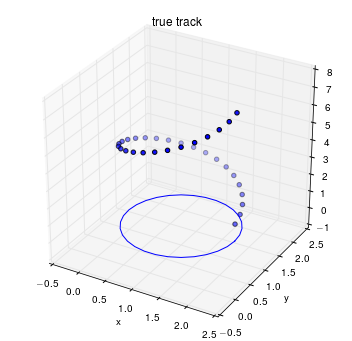

In [23]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*xtrue[:,:], marker='o')
plt.plot(xtrue[0].T, xtrue[1].T, color='b')
plt.title('true track')
plt.xlabel('x')
_n = plt.ylabel('y')

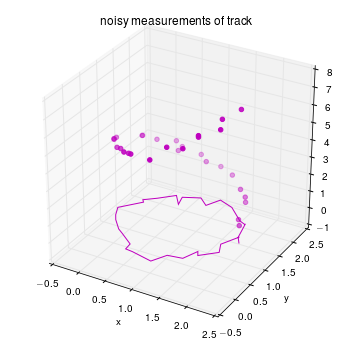

In [25]:
# add noise
measurement_noise = np.random.normal(loc=0, scale=sigma_pos, 
                                    size=xtrue.shape)
xmeas = xtrue + measurement_noise
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
plt.plot(xmeas[0].T, xmeas[1].T, color='m')
plt.title('noisy measurements of track')
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(*xmeas[:,:], marker='o', color='m')
plt.draw()

In [26]:
# predicted state vectors for each measurement 
xpredict = np.linspace(0, T, N * state_vec_dim).reshape((state_vec_dim, N))
# filtered state vectors for each measurement
xkal = np.linspace(0, T, N * state_vec_dim).reshape((state_vec_dim, N))
# set initial values
# the construction
for _i, _par in enumerate(true_params):
    xpredict[_i, 0] = _par + 0.1
    xkal[_i, 0] = _par + 0.1
# initial variance on prediction
p = np.identity(state_vec_dim)
# measurement error
r = sigma_pos * np.identity(xmeas.shape[0])
# prediction matrix
# global track parameters do not change in this example
A = np.identity(state_vec_dim)
# map state vector to measurements at surface k
H_k = [np.array([[1, 0, 0, 0, np.cos(t)],
                   [0, 1, 0, 0, np.sin(t)],
                   [0, 0, 1, t, 0]] ) for t in _t]
for i in range(1, N):
    H = H_k[i]
    # prediction: recursive formula
    xpredict[:, i] = np.dot(A, xkal[:, i - 1])
    p = np.dot(np.dot(A, p), A.T)
    K = np.dot(np.dot(p, H.T), 
            np.linalg.inv(np.dot(np.dot(H, p), H.T) + r))
    #print(_resid.shape)
    #print(xmeas4[:,i].shape)
    #print(K4.shape)
    #print(( K4 *  _resid).shape)
    #print( xpredict4[:, i].shape) 
    #print((H4 * np.matrix(xpredict[:,i])).shape)
    #_resid = ((np.array([xmeas[:,i]]).T - H * np.matrix(xpredict[:,i])))
    #xkal[:,i] = xpredict[:,i] + K * _resid 
    xkal[:, i] = xpredict[:, i] + np.dot(K, (xmeas[:, i] - np.dot(H, xpredict[:, i])))
    p = np.dot(np.eye(K.shape[0]) - np.dot(K, H), p)
    

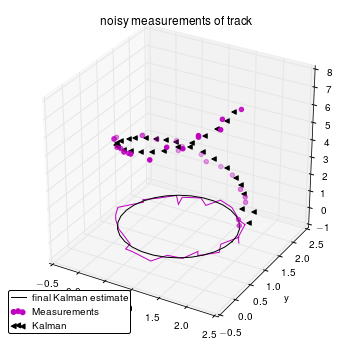

In [27]:

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
plt.plot(xmeas[0].T, xmeas[1].T, color='m')
plt.title('noisy measurements of track')
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(*xmeas[:,:], marker='o', color='m', label='Measurements')
for i in range(N):
    _plot_data = np.dot(H_k[i], xpredict[:, i])
    ax.scatter(*_plot_data, marker='<', color='black', label='Kalman' if i ==0 else '_')
_plot_data = []
for i in range(N):
    _plot_data.append(np.dot(H_k[i], xpredict[:, -1]))
_plot_data = np.array(_plot_data)
plt.plot(_plot_data[:, 0], _plot_data[:, 1], color='k', label='final Kalman estimate')
plt.legend(loc='lower left')
plt.draw()